In [1]:
%load_ext autoreload
%autoreload v2
%matplotlib inline

In [2]:
import os
import torch
import tqdm
import numpy as np
import matplotlib.pylab as plt

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import models
from torchvision import datasets, transforms, utils


In [3]:
from utils import get_imagenet_category_names, get_image_from_url
from visual import plot_classify, plot_image

/home/adam/.pyenv/versions/3.6.3/envs/3.6.3.exp/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [4]:
def preprocess_img(img):
    if isinstance(img, torch.Tensor):
        img = img.detach().numpy()
    img = np.transpose(img, (1, 2, 0))
  
    if img.shape[-1] == 3:
        if img.min() < 0:
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)
            
    img = np.transpose(img, (2, 0, 1))
    img = torch.Tensor(img)
    img = img.unsqueeze(0)
    return img
    
def get_uniq_image_grid(cos_sim, dataset, top_n=10, confidence=0.9):
    selected_images = []
    selected_couter = 0
    
    for idx in cos_sim.argsort(descending=True):
        if cos_sim[idx] < confidence:
            break
        if cos_sim[idx] == 1:
            continue
        
        insert = True
        new_image = dataset[idx][0]
        new_image = preprocess_img(new_image)
        
        for already_selected_image in selected_images:
            if torch.all(torch.eq(new_image, already_selected_image)):
                insert = False
                break
                
        if insert:
            selected_images.append(new_image)
            selected_couter += 1
            if selected_couter >= top_n:
                break
        
    images = torch.cat(selected_images)
    image_grid = utils.make_grid(images,nrow=4)
    image_grid = image_grid.detach().numpy()
    image_grid = np.transpose(image_grid, (1, 2, 0))
    return image_grid    
    

In [5]:
class IndexedImageFolder(datasets.ImageFolder):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def __getitem__(self, index):
        data, target = super().__getitem__(index)
        return data, target, index

### Check Resnet working

In [6]:
os.environ["TORCH_HOME"] = "./"

In [7]:
resnet18 = models.resnet18(pretrained=True)
info = resnet18.eval()

resnet18.fc = torch.nn.Sequential(
    resnet18.fc, 
    torch.nn.Softmax(dim=1))

In [8]:
transformation = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

dataset = datasets.ImageFolder('./dataset/', transformation)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4, sampler=torch.utils.data.SequentialSampler(dataset))

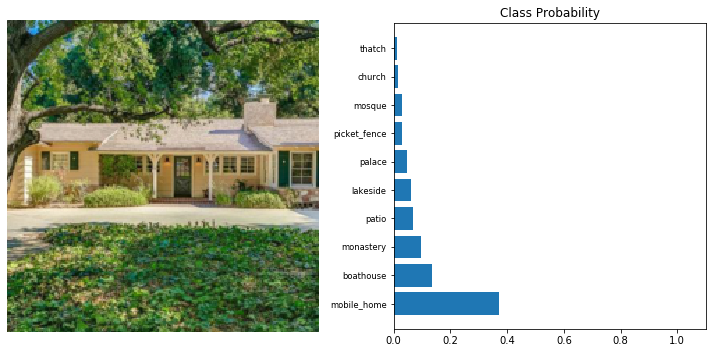

In [10]:
plot_classify(dataset[4][0], resnet18, topn=10, category_names=get_imagenet_category_names())

### Preparation of dataset

In [12]:
resnet18.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 2),
    torch.nn.Softmax(dim=1))

In [13]:
resnet18.load_state_dict(torch.load('resnet.pkl'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [14]:
resnet18_features = torch.nn.Sequential(*list(resnet18.children())[:-1])

In [15]:
cs = torch.nn.CosineSimilarity()

In [16]:
all_features = list()
all_indexes = list()
for img, label in tqdm.tqdm(loader):
    features = resnet18_features(img).squeeze().detach().numpy()
    all_features += features.tolist()
    
all_features_np = np.array(all_features) 

100%|██████████| 505/505 [06:48<00:00,  1.24it/s]


### Sample from dataset

In [38]:
target_idx = 765
target_img = torch.tensor(all_features_np[target_idx]).unsqueeze(0)

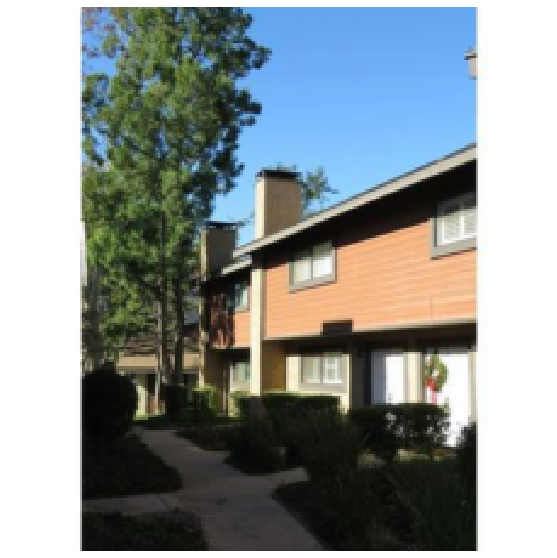

In [39]:
plot_image(dataset[target_idx][0])

### Sample from web

In [30]:
cozy = 'https://nilaya.asianpaints.com/wp-content/uploads/2018/10/cosy-up.jpg'
functional = 'http://erikaward.com/wp-content/uploads/2018/12/ErikaWardInteriors_CliftonRoadSunroom.jpg'
url = functional

In [31]:
transformation_url = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

img = get_image_from_url(url)
target_img = resnet18_features(transformation_url(img).unsqueeze(0)).squeeze().unsqueeze(0).double()

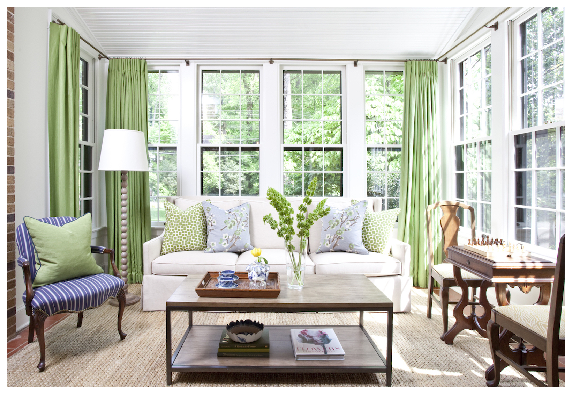

In [26]:
plot_image(img)

### Results

[]

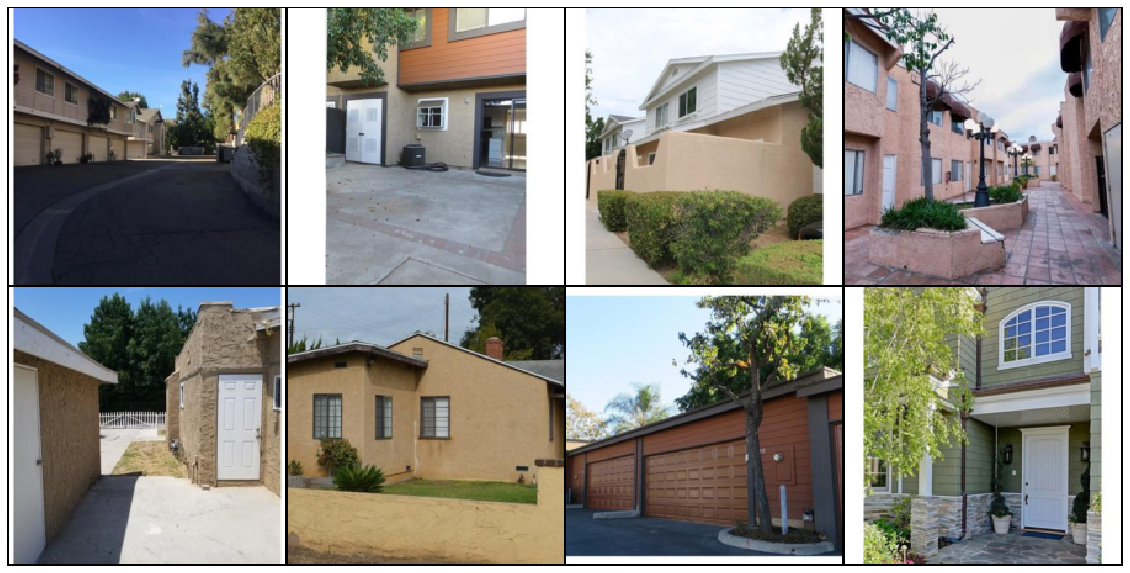

In [40]:
cos_sim = cs(target_img, torch.tensor(all_features_np))
image_grid = get_uniq_image_grid(cos_sim, dataset, top_n=8, confidence=0.8)


fig = plt.figure(figsize=(20, 20))
ax = plt.gca()
ax.imshow(image_grid, cmap='gray')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='both', length=0)
ax.set_xticklabels('')
ax.set_yticklabels('')